In [2]:
import networkx as nx
import json
import gzip
from collections import defaultdict
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


Se cargaron 23343 tweets.
Se detectaron 14834 retweets.
Ejemplo de pares usuario original → retweeter:
[('Trump_a_right', 'avengingautism'), ('DuckNazi', 'MayorOfFashtown'), ('mrb_rides_again', 'Spectreblackops'), ('mrb_rides_again', 'mohdhm2'), ('VixenRogue', 'PDXGREG')]


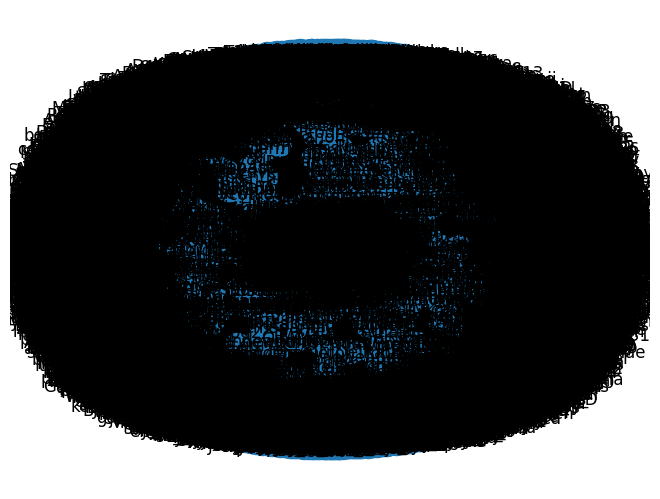

In [3]:
ruta_archivo = 'repealthe19th.jsonl.gz'
datos = []
retweets = []

with gzip.open(ruta_archivo, 'rt', encoding='utf-8') as archivo:
    for linea in archivo:
        try:
            tweet = json.loads(linea)
            datos.append(tweet)
            # Detectar si es un retweet
            if "retweeted_status" in tweet:
                original = tweet["retweeted_status"]["user"]["screen_name"]
                retweeter = tweet["user"]["screen_name"]
                
                if original != retweeter:  # evitar auto-bucles
                    retweets.append((original, retweeter))
        except json.JSONDecodeError:
            pass  

print(f"Se cargaron {len(datos)} tweets.")
print(f"Se detectaron {len(retweets)} retweets.")
print("Ejemplo de pares usuario original → retweeter:")
print(retweets[:5])

# Ahora si, crear un grafo dirigido con estos datos
D = nx.DiGraph()
D.add_edges_from(retweets)
nx.draw(D, with_labels=True)



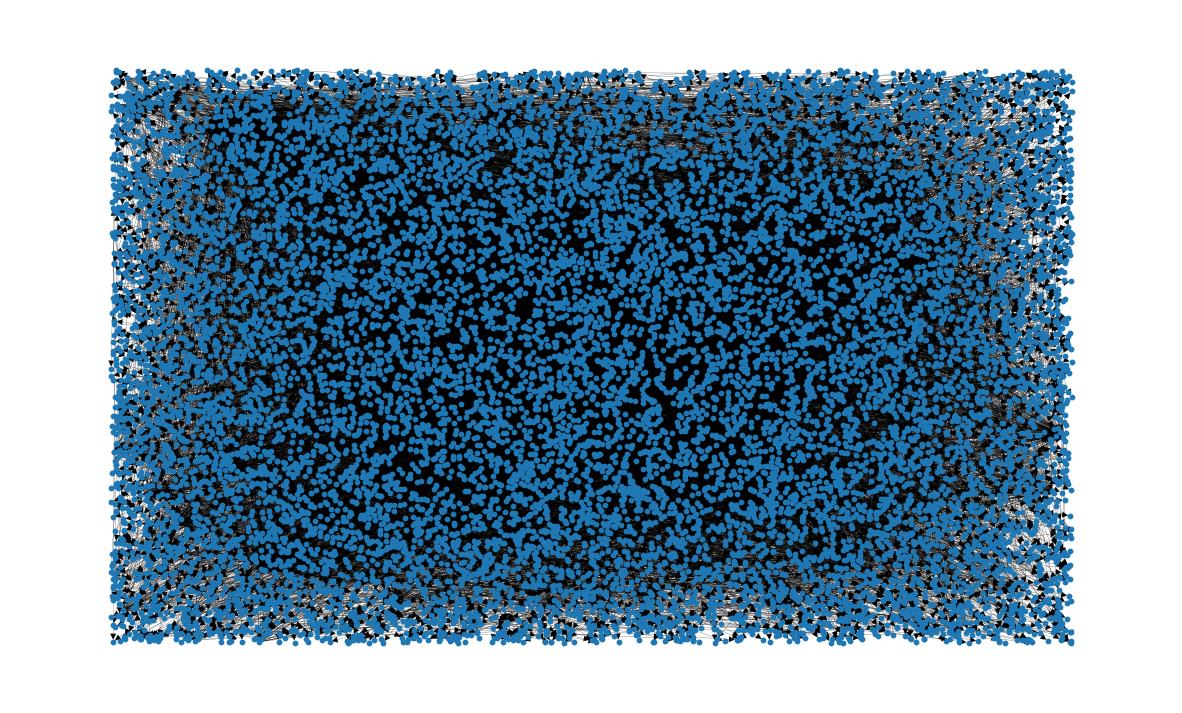

In [4]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(D, pos=nx.random_layout(D), ax=ax, **plot_options)

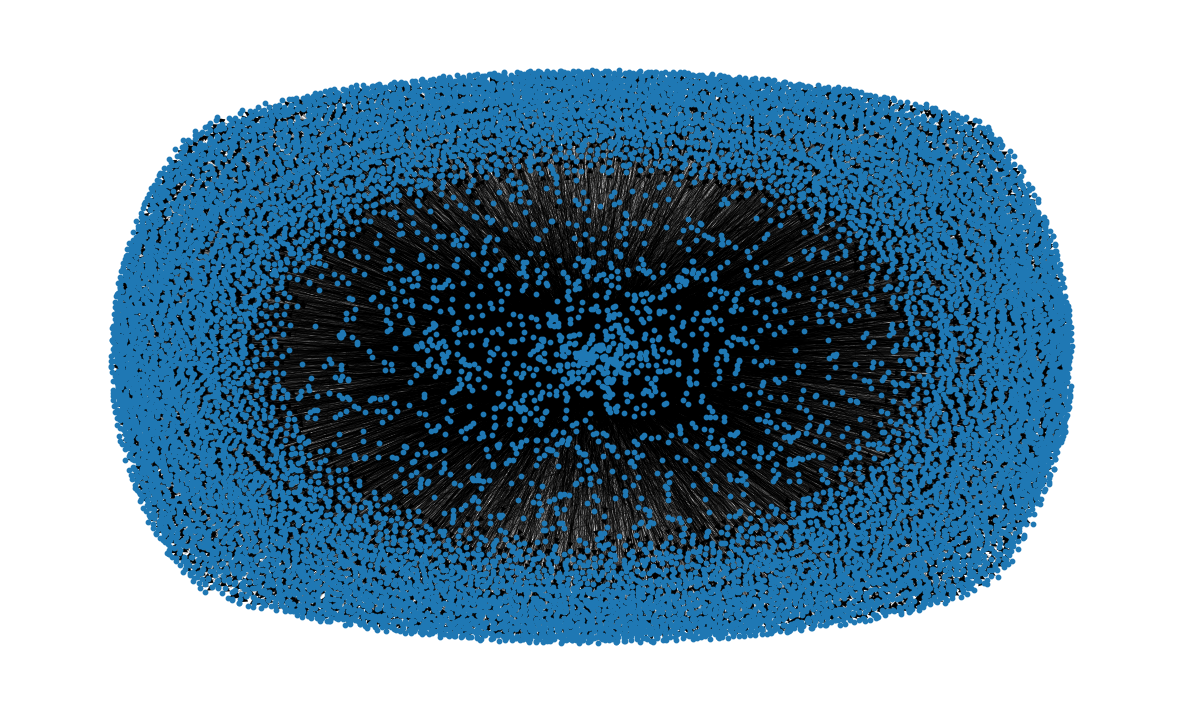

In [5]:
pos = nx.spring_layout(D, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(D, pos=pos, ax=ax, **plot_options)

In [6]:
from pyvis.network import Network
net = Network(notebook=True)
net.from_nx(D)
net.show('Retweets.html')

Retweets.html


### Cuantos nodos hay

In [7]:
num_nodos = D.number_of_nodes()
print(f"1. Nodos (usuarios únicos): {num_nodos}")


1. Nodos (usuarios únicos): 14862


### ¿Cuántos enlaces (aristas) hay?

In [8]:
num_aristas = D.number_of_edges()
print(f"2. Enlaces (retweets entre usuarios): {num_aristas}")


2. Enlaces (retweets entre usuarios): 14795


### ¿Quién fue el más retuiteado? (mayor out-strength)
Esto se refiere a cuántas veces alguien fue retuiteado, es decir, cuántas aristas salen de él hacia otros usuarios.

In [9]:
out_strengths = D.out_degree(weight='weight')
mas_retuiteado = max(out_strengths, key=lambda x: x[1])
print(f"3. Usuario más retuiteado: {mas_retuiteado[0]} → {mas_retuiteado[1]} retweets")


3. Usuario más retuiteado: Samandjunk → 900 retweets


### ¿Y el segundo más retuiteado?

In [10]:
ordenados = sorted(out_strengths, key=lambda x: x[1], reverse=True)
print(f"4. Segundo más retuiteado: {ordenados[1][0]} → {ordenados[1][1]} retweets")


4. Segundo más retuiteado: m_kaish_esq → 394 retweets


### ¿Cuál es el tuit más retuiteado? (id_str)
Aquí tienes que contar por retweeted_status["id_str"]

In [11]:
from collections import Counter

id_counter = Counter()

with gzip.open('repealthe19th.jsonl.gz', 'rt', encoding='utf-8') as archivo:
    for linea in archivo:
        tweet = json.loads(linea)
        if "retweeted_status" in tweet:
            original_id = tweet["retweeted_status"]["id_str"]
            id_counter[original_id] += 1

mas_rt = id_counter.most_common(1)[0]
print(f"5. Tweet más retuiteado → ID: {mas_rt[0]} → {mas_rt[1]} retweets")


5. Tweet más retuiteado → ID: 786335044981907456 → 901 retweets


### ¿Cuántos usuarios nunca retuitearon? (out-strength = 0)
Usuarios que nunca hicieron retweet a nadie, solo fueron retuiteados o no interactuaron

In [12]:
nunca_retuitearon = [n for n in D.nodes() if D.out_degree(n) == 0]
print(f"6. Usuarios que nunca retuitearon: {len(nunca_retuitearon)}")


6. Usuarios que nunca retuitearon: 12916


### ¿Qué tan conectada está la red?

In [13]:
# a) ¿Fuertemente conectada?
print("7. ¿Fuertemente conectada?", nx.is_strongly_connected(D))

# b) ¿Débilmente conectada?
print("   ¿Débilmente conectada?", nx.is_weakly_connected(D))

# c) Si ninguna de las dos, está desconectada
if not nx.is_weakly_connected(D):
    print("   La red está desconectada.")


7. ¿Fuertemente conectada? False
   ¿Débilmente conectada? False
   La red está desconectada.


### ¿Cuántos nodos hay en el componente débilmente conectado más grande?

In [14]:
componentes = nx.weakly_connected_components(D)
mayor_componente = max(componentes, key=len)
print(f"8. Nodos en el componente débilmente conectado más grande: {len(mayor_componente)}")


8. Nodos en el componente débilmente conectado más grande: 11909
